In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Análisis de homocedasticidad y heterocedasticidad

> Métodos para contrastar la homocedasticidad y heterocedasticidad de una muestra de datos con Python. Test de Levene, test de Bartlett y test de Fligner-Killeen.

## Introducción

El supuesto de homogeneidad de varianzas, también conocido como supuesto de homocedasticidad, considera que la varianza es constante (no varía) en los diferentes niveles de un factor, es decir, entre diferentes grupos. En los modelos de regresión lineal, esta condición de homocedasticidad suele hacer referencia a los errores (residuos) del modelo, es decir, que la varianza de los errores es constante en todas las predicciones. Cuando la condición de homocedasticidad no se cumple, se utiliza el término heterocedasticidad.

Existen diferentes test que permiten evaluar si las observaciones proceden de poblaciones con la misma varianza. Todos ellos consideran como hipótesis nula que la varianza es igual entre los grupos y como hipótesis alternativa que no lo es. La diferencia entre ellos es el estadístico de centralidad que utilizan:

- Los test que utilizan la media de la varianza son los que mayor poder estadístico consiguen cuando los datos siguen distribuciones normales.

- Los test que utilizan la mediana de la varianza consiguen mejores resultados cuando los datos siguen distribuciones asimétricas o se alejan de la normalidad.

Por lo general, si no se puede alcanzar cierta seguridad de que las poblaciones que se comparan son de tipo normal, es recomendable recurrir a test que comparen la mediana de la varianza.

A lo largo de este documento se muestra como realizar análisis gráficos y cómo aplicar el test de Levene, el test de Bartlett y el test de Fligner-Killeen con Python.


## Librerías

In [3]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Proprocesado y analisis
import statsmodels.api as sm
from scipy import stats


import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)
sns.set_theme(style="whitegrid", context="notebook", palette="pastel")

## Datos

Los datos utilizados en este ejemplo se han obtenido del libro Statistical Rethinking by Richard McElreath. El set de datos contiene información recogida por Nancy Howell a finales de la década de 1960 sobre el pueblo !Kung San, que viven en el desierto de Kalahari entre Botsuana, Namibia y Angola. El objetivo es identificar si existe diferencia entre la varianza del peso de hombres y mujeres.


In [4]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/' +
       'Estadistica-machine-learning-python/master/data/Howell1.csv')
datos = pd.read_csv(url)

In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [8]:
datos.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


De todos los datos disponibles se seleccionan únicamente personas con más de 15 años.

In [9]:
datos['male'] = datos['male'].astype(str)

datos = datos[(datos['age'] > 15)]

peso_hombres = datos.loc[datos['male'] == '1', 'weight']
peso_mujeres = datos.loc[datos['male'] == '0', 'weight']

## Métodos gráficos

Dos de los métodos gráficos más empleados para el análisis homocedasticidad consiste en representar los datos mediante un boxplot o un violinplot. Con ambos gráficos el objetivo es comparar la dispersión de los grupos.

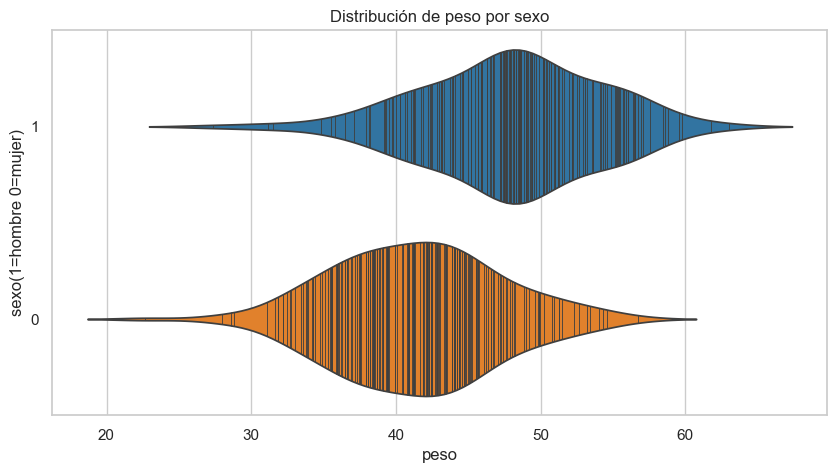

In [11]:
# Grafico Violinplot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.violinplot(
    x       = 'weight',
    y       = 'male',
    data    = datos,
    palette = 'tab10',
    inner   = 'stick',
    ax      = ax
)
ax.set_title('Distribución de peso por sexo')
ax.set_xlabel('peso')
ax.set_ylabel('sexo(1=hombre 0=mujer)')
plt.show()

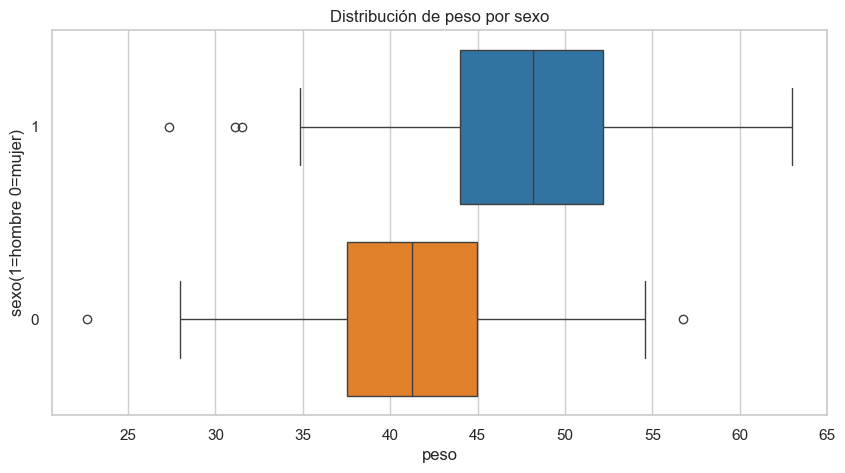

In [13]:
# Grafico Boxplot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(
    x       = 'weight',
    y       = 'male',
    data    = datos,
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de peso por sexo')
ax.set_xlabel('peso')
ax.set_ylabel('sexo(1=hombre 0=mujer)')
plt.show()

El análisis gráfico parece indicar que los dos grupos tienen varianzas similares.

## Contraste de hipótesis

**El test de Levene**, el **test de Bartlett** y el **test de Fligner-Killeen** son tres de los test de hipótesis más empleados comparar la _varianza_ entre grupos. En todos ellos, se considera como hipótesis nula que los datos proceden de distribuciones con la misma varianza **(homocedasticidad)**. Por lo tanto, si el `p-value` es menor que un determinado **valor (típicamente 0.05)**, entonces se considera que hay evidencias suficientes para rechazar la **homocedasticidad** en favor de la **heterocedasticidad**.

El **test de Levene** y el **test de Fligner-Killeen (este último no paramétrico)** son más robustos que el test de **Bartlett** ante la falta de normalidad, por lo que suele aconsejarse su uso. Además, tanto el test de Levene como el de Bartlett permiten elegir entre diferentes estadísticos de centralidad: mediana (por defecto), media, media truncada. Esto es importante a la hora de contrastar la homocedasticidad dependiendo de si los grupos se distribuyen de forma normal o no.

Si se tiene seguridad de que las muestras a comparar proceden de poblaciones que siguen una distribución normal, es recomendable el test de Bartlett. Si no se tiene la seguridad de que las poblaciones de origen son normales, se recomiendan el test de Leven utilizando la mediana o el test no paramétrico Fligner-Killeen que también se basa en la mediana.

Los tres test están disponibles en la librería `scipy.stats` (`scipy.stats.levene`, `scipy.stats.bartlett`, `scipy.stats.fligner`) y en la librería `pingouin` (`pingouin.homoscedasticity`).

In [14]:
# Levene test

levene_test = stats.levene(peso_hombres, peso_mujeres, center='median')

levene_test

LeveneResult(statistic=0.18630521976263306, pvalue=0.6662611053126026)

In [15]:
# Bartlett test

bartlett_test = stats.bartlett(peso_hombres, peso_mujeres)
bartlett_test

BartlettResult(statistic=0.8473322751459793, pvalue=0.3573081212488608)

In [17]:
# Fligner test
fligner_test = stats.fligner(peso_hombres, peso_mujeres, center='median')
fligner_test

FlignerResult(statistic=0.1376531343594324, pvalue=0.7106253515287645)

Ninguno de los test muestra evidencias para rechazar la hipótesis de que los dos grupos tienen la misma varianza, _homocedasticidad_. **p-value >>>> 0.05**.